# Reorganization of Popescu's annotation datasets


## Purpose of this notebook
This notebook describes the steps involved in gathering, cleaning up and reorganizing the minke whale pulse train manual annotations that were used by Popescu et al to train and test a minke whale detector.

Popescu, M., Dugan, P.J., Pourhomayoun, M., Risch, D., Lewis, H., & Clark, C.W. (2013). Bioacoustical Periodic Pulse Train Signal Detection and Classification using Spectrogram Intensity Binarization and Energy Projection. ArXiv, abs/1305.3250.

https://www.semanticscholar.org/paper/Bioacoustical-Periodic-Pulse-Train-Signal-Detection-Popescu-Dugan/951092c1582ae412e62de4ad2728bceccc182206

The specific objectives of this notebook are:

- Reorganize the audio data so they are sorted by deployment and locations
- Convert the Raven annotation tables to have annotation times relative to the beginning of each audio file.
- Add metadata to all annotations (i.e., coordinates, depths, location, dates, etc)
- Make annotation labels consistent (i.e. 'MW' for minke, 'NN' for noise)


## Description of the data and manual annotations

The original dataset from Popescu has the data split up into 9 subsets (i.e. folders). Each subset contains the audio data in aif format along with a Raven annotation table file "masterlog.txt". Data from each subset can come from different deployments and locations. The annotation times in the Raven tables are relative to the first file of the subset. SO to see teh annotations baxes in Raven, one must load all the files of the subset and then load teh annotation table. Subsets 1-5 contain mostly minke whale pulse trains, while subsets 6-9 are not annotated and only contain noise examples. 

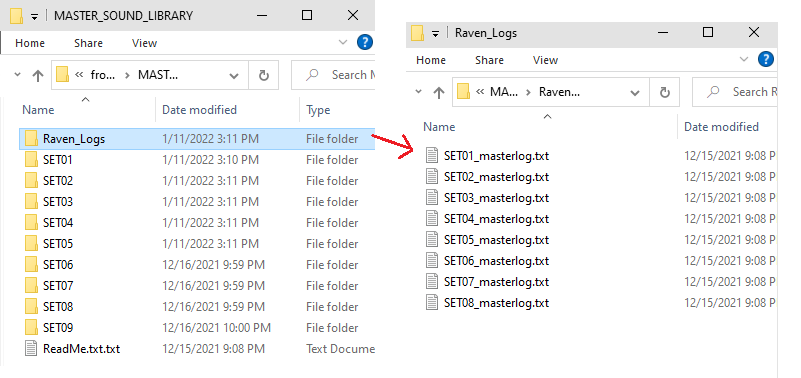


## Adding annotation fields in Raven

Since the times of the original annotations are relative to the first file of each subset, we need to add additional fields so we can recalculate annotation times relative to the start of each audio file. This will make the manipulation of annotations much easier and cleaner.

1. Open all files from a same subset in Raven
2. Load the annotation table "...masterlog.txt"
3. Click right on the header section of the annotation table in Raven, then select "Choose Measurements..."
4. Add the measurements "File Offset (s)", "Begin File", and "Begin Path".
5. Save the updated annotation table (File > Save Selection Table). In the rest of this notebook this new table file is called "old_masterlog_modified.txt"


## Reorganization of the data into separate deployment folders

The 9 data subsets are now broken down into multiple folder corresponding to different deployments. The corresponding Raven annotations table is also placed is each deployment folder. Since the original annotations had data from several deployments/locations, it is necesarry to edit the annotation table files, so they only contain annotations from a single deployment.

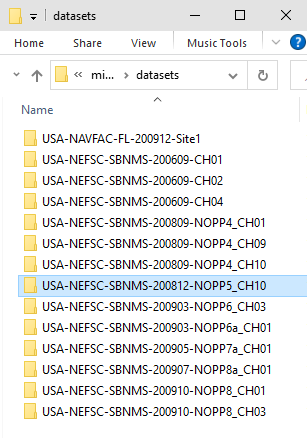

## Import libraries and define functions used throughout

In [1]:
import os
from ecosound.core.annotation import Annotation
from ecosound.core.metadata import DeploymentInfo
from ecosound.core.audiotools import Sound
import pandas as pd
from datetime import datetime
import re
import uuid

def get_datetime_from_filename(filename):
    time_format = "%Y%m%d_%H%M%S"
    file_offset_s_regex = "_[0-9]+s"
    file_offset_ms_regex = "_[0-9]+s"
    file_orig_regex = "_[0-9]{8}_[0-9]{6}_"    
    # first part - date/time of origninal audio file
    p1 = re.compile(file_orig_regex)
    datestr_1 = p1.search(filename)
    date = datetime.strptime(datestr_1[0][1:-1],time_format)    
    ## second part - nb of seconds
    #p1 = re.compile(file_orig_regex)
    #datestr_1 = p1.search(df['Begin File'].iloc[0])
    #date = datetime.strptime(datestr_1[0][1:-1],time_format)    
    return date   

def load_raven_table(root_dir,audio_dir,annotation_file,deployment_file):
    ## load Raven annotations
    df = pd.read_csv(os.path.join(root_dir, annotation_file), sep='\t')
    df = df[df['View']== 'Spectrogram 1'] # remove all "waveform" rows (redundant with the "Spectrogram" ones)
    df = df.reset_index(drop=True)    
    ## find out start date/time for each audio file
    files_date=df['Begin File'].apply(get_datetime_from_filename)
    # Definition of start and stop time offsets of annoatations (relative to start of each audio file)
    duration = df['End Time (s)']-df['Begin Time (s)']
    start_offset = df['File Offset (s)']
    end_offset = start_offset + duration
    ## Populate annotation object
    annot = Annotation()
    annot.data['audio_file_start_date'] = files_date
    annot.data['audio_channel'] = df['Channel']-1
    annot.data['audio_file_name'] = df['Begin File'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    annot.data['audio_file_dir'] = audio_dir
    annot.data['audio_file_extension'] = df['Begin Path'].apply(lambda x: os.path.splitext(x)[1])
    annot.data['time_min_offset'] = start_offset
    annot.data['time_max_offset'] = end_offset
    annot.data['time_min_date'] = pd.to_datetime(annot.data['audio_file_start_date'] + pd.to_timedelta(annot.data['time_min_offset'], unit='s'))
    annot.data['time_max_date'] = pd.to_datetime(annot.data['audio_file_start_date'] + pd.to_timedelta(annot.data['time_max_offset'], unit='s'))
    annot.data['frequency_min'] = df['Low Freq (Hz)']
    annot.data['frequency_max'] = df['High Freq (Hz)']    
    annot.data['label_class'] = df['tags']
    annot.data['from_detector'] = False
    annot.data['software_name'] = 'raven'
    annot.data['uuid'] = annot.data.apply(lambda _: str(uuid.uuid4()), axis=1)
    annot.data['duration'] = annot.data['time_max_offset'] - annot.data['time_min_offset']
    annot.insert_metadata(os.path.join(root_dir, deployment_file)) # insert metadata
    annot.check_integrity(verbose=True, ignore_frequency_duplicates=True) # check integrity
    print(len(annot), 'annotations imported.')
    return annot

def create_noise_annot(root_dir, audio_dir, deployment_file, dates_available=False):
    file_list = os.listdir(audio_dir)
    Deployment = DeploymentInfo()
    Deployment.read(os.path.join(root_dir, deployment_file))
    annot_full = Annotation()
    for File in file_list:
        filename = os.path.join(audio_dir,File)
        file = Sound(filename)
        file.file_duration_sec
        ## Populate annotation object
        annot = Annotation()
        annot.data['audio_channel'] = [0]
        annot.data['audio_file_name'] = os.path.splitext(os.path.basename(filename))[0]
        annot.data['audio_file_dir'] = audio_dir
        annot.data['audio_file_extension'] = os.path.splitext(filename)[1]
        annot.data['time_min_offset'] = 0.1
        annot.data['time_max_offset'] = file.file_duration_sec - 0.1
        annot.data['frequency_min'] = 0
        annot.data['frequency_max'] = file.file_sampling_frequency/2    
        annot.data['label_class'] = 'NN'
        annot.data['from_detector'] = False
        annot.data['software_name'] = 'raven'
        annot.data['uuid'] = str(uuid.uuid4())
        annot.data['duration'] = annot.data['time_max_offset'] - annot.data['time_min_offset']
        annot.insert_metadata(os.path.join(root_dir, deployment_file)) # insert metadata
        if dates_available:
            file_date= get_datetime_from_filename(filename)
            annot.data['audio_file_start_date'] = file_date
            annot.data['time_min_date'] = pd.to_datetime(file_date)
            annot.data['time_max_date'] = pd.to_datetime(file_date)
        else:
            annot.data['audio_file_start_date'] = Deployment.data.deployment_date
            annot.data['time_min_date'] = pd.to_datetime(Deployment.data.deployment_date)
            annot.data['time_max_date'] = pd.to_datetime(Deployment.data.deployment_date)
        annot.insert_metadata(os.path.join(root_dir, deployment_file)) # insert metadata
        
        #annot.check_integrity(verbose=True, ignore_frequency_duplicates=True) # check integrity
        #print(len(annot), 'annotations imported.')
        annot.data.operator_name='Popescu'
        annot_full = annot_full + annot
    return annot_full

## Create deployment info files with metadata for each deployment

Instantiate a DeploymentInfo object to handle metadata for the deployment, and create an empty deployment info file.

In [2]:
# Instantiate
Deployment = DeploymentInfo()
# write empty file to fill in (do once only)
#Deployment.write_template(os.path.join(root_dir, deployment_file))

A csv file "deployment_info.csv" has now been created in the root_dir. It is empty and only has column headers, and includes teh following fiilds:

* audio_channel_number
* UTC_offset
* sampling_frequency (in Hz)
* bit_depth 
* mooring_platform_name
* recorder_type
* recorder_SN
* hydrophone_model
* hydrophone_SN
* hydrophone_depth
* location_name
* location_lat
* location_lon
* location_water_depth
* deployment_ID
* deployment_date
* recovery_date

This file needs to be filled in by the user with the appropriate deployment information. Once filled in, the file can be loaded using the Deployment object:

## Cleaning annotations

Now we go through the annotations for each deployment/dataset and add the associated metadata, correct inconsistencies in annotations labels, and save as a NetCDF and Raven file. 

### Dataset 1: USA-NAVFAC-FL-200912-Site1

Definition of all the paths of all folders with the raw annotation and audio files for this deployment.

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NAVFAC-FL-200912-Site1'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NAVFAC-FL-200912-Site1'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

Now we can load and format the manual annotations for this dataset and add the metadata. 

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

Let's look at the different annotation labels that were used:

In [ ]:
print(annot.get_labels_class())

Let's change 'Bac_3100' to 'MW' (Minke whale) and nan for 'NN' (noise):

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.get_labels_class())

Now, having a look a summary of all the annotations available in this dataset.

In [ ]:
# print summary (pivot table)
print(annot.summary())

The dataset can now be saved as a Raven annotation file and netcdf4 file:

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 2: USA-NEFSC-SBNMS-200609-CH01
Now we can repeat the step above for all the other datasets:

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200609-CH01'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200609-CH01'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100', 'minke_pt'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 3: USA-NEFSC-SBNMS-200609-CH02

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200609-CH02'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200609-CH02'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 4: USA-NEFSC-SBNMS-200609-CH04

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200609-CH04'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200609-CH04'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 5: USA-NEFSC-SBNMS-200809-NOPP4_CH01

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200809-NOPP4_CH01'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200809-NOPP4_CH01'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 6: USA-NEFSC-SBNMS-200809-NOPP4_CH09

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200809-NOPP4_CH09'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200809-NOPP4_CH09'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 7: USA-NEFSC-SBNMS-200809-NOPP4_CH10

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200809-NOPP4_CH10'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200809-NOPP4_CH10'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 8: USA-NEFSC-SBNMS-200812-NOPP5_CH10 (Noise)

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200812-NOPP5_CH10'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200812-NOPP5_CH10'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

No annotations in this dataset, only unannotated noise samples

### Dataset 9: USA-NEFSC-SBNMS-200903-NOPP6_CH03

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200903-NOPP6_CH03'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200903-NOPP6_CH03'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 10: USA-NEFSC-SBNMS-200903-NOPP6a_CH01 (Noise)

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200903-NOPP6a_CH01'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200903-NOPP6a_CH01'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 11: USA-NEFSC-SBNMS-200905-NOPP7a_CH01

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200905-NOPP7a_CH01'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200905-NOPP7a_CH01'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 12: USA-NEFSC-SBNMS-200907-NOPP8a_CH01

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200907-NOPP8a_CH01'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200907-NOPP8a_CH01'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 13: USA-NEFSC-SBNMS-200910-NOPP8_CH01

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200910-NOPP8_CH01'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200910-NOPP8_CH01'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100', 'minke_pt'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Dataset 14: USA-NEFSC-SBNMS-200910-NOPP8_CH03

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200910-NOPP8_CH03'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200910-NOPP8_CH03'
deployment_file = r'deployment_info.csv' 
annotation_file = r'old_masterlog_modified.txt'

In [ ]:
annot = load_raven_table(root_dir,audio_dir,annotation_file,deployment_file)

In [ ]:
print(annot.get_labels_class())

In [ ]:
annot.data['label_class'].replace(to_replace=['Bac_3100', 'minke_pt'], value='MW', inplace=True)
annot.data.loc[annot.data['label_class'].isnull(),'label_class'] = 'NN'
print(annot.summary())

In [ ]:
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(root_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

## Creating noise annotations

Several deployments have data only with noise (i.e. anything but minke). These noise recordings are not annotated per se, so to make our life easier later on, we need to create noise annotations tables for these recordings too.

### Noise dataset 1: USA-NAVFAC-FL-200912-Site1

In [16]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NAVFAC-FL-200912-Site1'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NAVFAC-FL-200912-Site1\noise'
deployment_file = r'deployment_info.csv' 

annot = create_noise_annot(root_dir, audio_dir, deployment_file)
print(annot.summary())

label_class                 NN  Total
deployment_ID                        
USA-NAVFAC-FL-200912-Site1  94     94
Total                       94     94


In [17]:
# Now save noise annotations
annot.to_netcdf(os.path.join(audio_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(audio_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

C:\Users\xavier.mouy\Anaconda3\envs\ecosound\lib\site-packages\pandas\core\arrays\timedeltas.py:754: RuntimeWarning: invalid value encountered in multiply
  return self - (self // other) * other


### Noise dataset 2: USA-NEFSC-SBNMS-200812-NOPP5_CH10

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200812-NOPP5_CH10'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200812-NOPP5_CH10\noise'
deployment_file = r'deployment_info.csv' 

annot = create_noise_annot(root_dir, audio_dir, deployment_file)
print(annot.summary())

In [ ]:
# Now save noise annotations
annot.to_netcdf(os.path.join(audio_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(audio_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

### Noise dataset 3: USA-NEFSC-SBNMS-200903-NOPP6a_CH01

In [3]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200903-NOPP6a_CH01'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200903-NOPP6a_CH01\noise'
deployment_file = r'deployment_info.csv' 

annot = create_noise_annot(root_dir, audio_dir, deployment_file)
print(annot.summary())

label_class                          NN  Total
deployment_ID                                 
USA-NEFSC-SBNMS-200903-NOPP6a_CH01  263    263
Total                               263    263


In [4]:
# Now save noise annotations
annot.to_netcdf(os.path.join(audio_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(audio_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

C:\Users\xavier.mouy\Anaconda3\envs\ecosound\lib\site-packages\pandas\core\arrays\timedeltas.py:754: RuntimeWarning: invalid value encountered in multiply
  return self - (self // other) * other


### Noise dataset 4: USA-NEFSC-SBNMS-200912-NOPP9_CH10

In [ ]:
root_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200912-NOPP9_CH10'
audio_dir = r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200912-NOPP9_CH10\noise'
deployment_file = r'deployment_info.csv' 

annot = create_noise_annot(root_dir, audio_dir, deployment_file, dates_available=True)
print(annot.summary())

In [ ]:
# Now save noise annotations
annot.to_netcdf(os.path.join(audio_dir, 'Annotations_dataset_' + annot.data['deployment_ID'][0] +' annotations.nc'))
annot.to_raven(audio_dir, outfile='Annotations_dataset_' + annot.data['deployment_ID'][0] +'.Table.1.selections.txt', single_file=True)

## Merging all datasets together

Now that all our datasets are cleaned up and standardized, we can merge them all in a single Master annotation dataset.

In [18]:
root_dir =r'C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets'
dataset_files = [r'\USA-NAVFAC-FL-200912-Site1\Annotations_dataset_USA-NAVFAC-FL-200912-Site1 annotations.nc',
                 r'\USA-NAVFAC-FL-200912-Site1\noise\Annotations_dataset_USA-NAVFAC-FL-200912-Site1 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200609-CH01\Annotations_dataset_USA-NEFSC-SBNMS-200609-CH01 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200609-CH02\Annotations_dataset_USA-NEFSC-SBNMS-200609-CH02 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200609-CH04\Annotations_dataset_USA-NEFSC-SBNMS-200609-CH04 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200809-NOPP4_CH01\Annotations_dataset_USA-NEFSC-SBNMS-200809-NOPP4_CH01 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200809-NOPP4_CH09\Annotations_dataset_USA-NEFSC-SBNMS-200809-NOPP4_CH09 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200809-NOPP4_CH10\Annotations_dataset_USA-NEFSC-SBNMS-200809-NOPP4_CH10 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200812-NOPP5_CH10\noise\Annotations_dataset_USA-NEFSC-SBNMS-200812-NOPP5_CH10 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200903-NOPP6_CH03\Annotations_dataset_USA-NEFSC-SBNMS-200903-NOPP6_CH03 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200903-NOPP6a_CH01\Annotations_dataset_USA-NEFSC-SBNMS-200903-NOPP6a_CH01 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200903-NOPP6a_CH01\noise\Annotations_dataset_USA-NEFSC-SBNMS-200903-NOPP6a_CH01 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200905-NOPP7a_CH01\Annotations_dataset_USA-NEFSC-SBNMS-200905-NOPP7a_CH01 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200907-NOPP8a_CH01\Annotations_dataset_USA-NEFSC-SBNMS-200907-NOPP8a_CH01 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200910-NOPP8_CH01\Annotations_dataset_USA-NEFSC-SBNMS-200910-NOPP8_CH01 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200910-NOPP8_CH03\Annotations_dataset_USA-NEFSC-SBNMS-200910-NOPP8_CH03 annotations.nc',
                 r'\USA-NEFSC-SBNMS-200912-NOPP9_CH10\noise\Annotations_dataset_USA-NEFSC-SBNMS-200912-NOPP9_CH10 annotations.nc',                 
                ]

Looping through each dataset and merging in to a master dataset:

In [20]:
# # load all annotations
annot = Annotation()
for file in dataset_files:
    print(root_dir + file)
    tmp = Annotation()
    #tmp.from_netcdf(os.path.join(root_dir, file), verbose=True)
    tmp.from_netcdf((root_dir + file), verbose=True)
    annot = annot + tmp
    #print(set(tmp.data['audio_file_dir']))
    #print(' ')
    #print(' ')
annot.check_integrity()

C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NAVFAC-FL-200912-Site1\Annotations_dataset_USA-NAVFAC-FL-200912-Site1 annotations.nc
Duplicate entries removed: 0
Integrity test succesfull
61 annotations imported.
C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NAVFAC-FL-200912-Site1\noise\Annotations_dataset_USA-NAVFAC-FL-200912-Site1 annotations.nc
Duplicate entries removed: 0
Integrity test succesfull
94 annotations imported.
C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200609-CH01\Annotations_dataset_USA-NEFSC-SBNMS-200609-CH01 annotations.nc
Duplicate entries removed: 0
Integrity test succesfull
39 annotations imported.
C:\Users\xavier.mouy\Documents\GitHub\minke-whale-dataset\datasets\USA-NEFSC-SBNMS-200609-CH02\Annotations_dataset_USA-NEFSC-SBNMS-200609-CH02 annotations.nc
Duplicate entries removed: 0
Integrity test succesfull
14 annotations imported.
C:\Users\xavier.mouy\Documents\GitHub\minke-wh

In [21]:
print(annot.summary())

label_class                           MW    NN  Total
deployment_ID                                        
USA-NAVFAC-FL-200912-Site1            61    94    155
USA-NEFSC-SBNMS-200609-CH01           39     0     39
USA-NEFSC-SBNMS-200609-CH02           14     0     14
USA-NEFSC-SBNMS-200609-CH04          518   151    669
USA-NEFSC-SBNMS-200809-NOPP4_CH01    381    96    477
USA-NEFSC-SBNMS-200809-NOPP4_CH09    304    75    379
USA-NEFSC-SBNMS-200809-NOPP4_CH10    454   110    564
USA-NEFSC-SBNMS-200812-NOPP5_CH10      0   755    755
USA-NEFSC-SBNMS-200903-NOPP6_CH03      3    22     25
USA-NEFSC-SBNMS-200903-NOPP6a_CH01     0   267    267
USA-NEFSC-SBNMS-200905-NOPP7a_CH01    10   256    266
USA-NEFSC-SBNMS-200907-NOPP8a_CH01   156    20    176
USA-NEFSC-SBNMS-200910-NOPP8_CH01    484   155    639
USA-NEFSC-SBNMS-200910-NOPP8_CH03      2     4      6
USA-NEFSC-SBNMS-200912-NOPP9_CH10      0   543    543
Total                               2426  2548   4974


In [22]:
# Now save master annotation dataset
annot.to_netcdf(os.path.join(root_dir, 'Annotations_dataset_' + "-".join(annot.get_labels_class()) + '_' + datetime.today().strftime('%Y%m%dT%H%M%S') + '.nc'))

C:\Users\xavier.mouy\Anaconda3\envs\ecosound\lib\site-packages\pandas\core\arrays\timedeltas.py:754: RuntimeWarning: invalid value encountered in multiply
  return self - (self // other) * other


In [23]:
annot.check_integrity()
annot.summary()

label_class,MW,NN,Total
deployment_ID,,,
USA-NAVFAC-FL-200912-Site1,61,94,155
USA-NEFSC-SBNMS-200609-CH01,39,0,39
USA-NEFSC-SBNMS-200609-CH02,14,0,14
USA-NEFSC-SBNMS-200609-CH04,518,151,669
USA-NEFSC-SBNMS-200809-NOPP4_CH01,381,96,477
USA-NEFSC-SBNMS-200809-NOPP4_CH09,304,75,379
USA-NEFSC-SBNMS-200809-NOPP4_CH10,454,110,564
USA-NEFSC-SBNMS-200812-NOPP5_CH10,0,755,755
USA-NEFSC-SBNMS-200903-NOPP6_CH03,3,22,25
